In [1]:
#pip install pywavelets

In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import pywt

In [2]:
import matplotlib.pyplot as plt

In [3]:
df1 = pd.read_csv('train.csv')
df2= pd.read_csv('test.csv')

<ipython-input-4-3baf53453abd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['zone'][13100:14297]=1;
<ipython-input-4-3baf53453abd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['zone'][19890:21410]=1;
<ipython-input-4-3baf53453abd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['zone'][:1925]=1;
<ipython-input-4-3baf53453abd>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

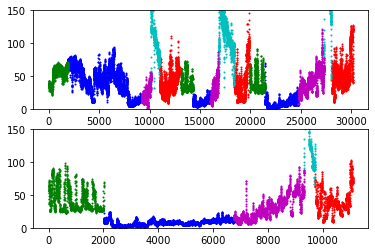

In [4]:
# Petrophysics-based zonation for both training and test set based on GR, ZDEN, CNC. Compared to test set,
# we found the training set showed similar spatial patterns, to take advantage of the spatial correlation
# we performed inter-well correlation. Per-zone estimation has been proved to be a good preprocessing method for well-log
# interpretation (Pan et al., in press; Pan et al., 2019)
df1['zone']=0
df1['zone'][13100:14297]=1;
df1['zone'][19890:21410]=1;
df1['zone'][:1925]=1;
#df1['zone'][1925:7000] no corresponding zone
#df1['zone'][7000:9210] DTS missing



df1['zone'][28022:]=2;
df1['zone'][18400:19888]=2;
df1['zone'][10993:12997]=2;

df1['zone'][27276:28022]=3;
df1['zone'][16823:18400]=3;
df1['zone'][10142:10993]=3;

df1['zone'][24753:27276]=4;
df1['zone'][16037:16823]=4;
df1['zone'][9210:10142]=4;

df2['zone']=0
df2['zone'][:2010]=1
df2['zone'][6749:9316]=4
df2['zone'][9316:9710]=3
df2['zone'][9710:]=2

co=['b','g','r','c','m','y']

# Figures show the patterns of gamma ray for different zones
for i in range(6):
    plt.subplot(2, 1, 1)
    plt.scatter(df1.index[df1.zone.values==i],df1.GR.values[df1.zone.values==i],s=1,color=co[i])
    plt.ylim([0,150])
    plt.subplot(2, 1, 2)
    plt.scatter(df2.index[df2.zone.values==i],df2.GR.values[df2.zone.values==i],s=1,color=co[i])
    plt.ylim([0,150])

In [5]:
df1['CNC'][df1['CNC']>0.6]=np.nan
df1['CNC'][df1['CNC']<-0.15]=np.nan

<ipython-input-5-2309d5a86a8a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['CNC'][df1['CNC']>0.6]=np.nan
<ipython-input-5-2309d5a86a8a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['CNC'][df1['CNC']<-0.15]=np.nan


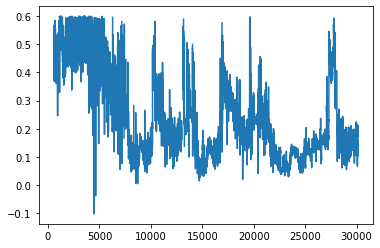

In [6]:
plt.plot(df1['CNC'])

In [7]:
# Delete points where data are missing 
df1=df1[['CNC','GR','ZDEN','HRD','DTC','DTS','zone','CAL','HRM','PE']]
df1.replace(['-999', -999], np.nan, inplace=True)
df1.dropna(axis=0, inplace=True)
df2=df2[['CNC','GR','ZDEN','HRD','zone','CAL','HRM','PE']]
df2.replace(['-999', -999], np.nan, inplace=True)
df2.dropna(axis=0, inplace=True)

DTC2=np.zeros(df2.shape[0])# array for saving predictions
DTS2=np.zeros(df2.shape[0])

In [8]:
depth_train= np.linspace(500,4000,len(df1))
depth_test= np.linspace(1500,3000,len(df2))

In [9]:
df1['Depth']= depth_train
df2['Depth']= depth_test

In [10]:
df1.shape

(20068, 11)

In [11]:
df2.shape ## test data

(11088, 9)

Wavelet Transformation on Train data

In [12]:
#This function is defined for descrete wavelet transform and calculating the cA ie the approximate coefficient
def make_dwt_vars_cA(wells_df,logs,levels,wavelet):

    wave= pywt.Wavelet(wavelet)
    
    grouped = wells_df
    new_df = pd.DataFrame()
    for key in grouped.keys():
    
        depth = grouped['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped[log]
              
            for i in levels:
                
                    cA_cD = pywt.wavedec(temp_data,wave,level=i,mode='symmetric')
                    cA = cA_cD[0]
                    new_depth = np.linspace(min(depth),max(depth),len(cA))
                    fA = interp1d(new_depth,cA,kind='nearest')
                    temp_df[log + '_cA_level_' + str(i)] = fA(depth)
    
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Depth'],axis=1)
    return new_df

In [13]:

#This is a user defined function for discrte wavelet transform cD, cD is also called the detailed  coefficient
def make_dwt_vars_cD(wells_df,logs,levels,wavelet):

    wave= pywt.Wavelet(wavelet)
    
    grouped = wells_df
    new_df = pd.DataFrame()
    for key in grouped.keys():
    
        depth = grouped['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped[log]

            cA_4, cD_4, cD_3, cD_2, cD_1 = pywt.wavedec(temp_data,wave,level=4,mode='symmetric')
            dict_cD_levels = {1:cD_1, 2:cD_2, 3:cD_3, 4:cD_4}
                
            for i in levels:
                new_depth = np.linspace(min(depth),max(depth),len(dict_cD_levels[i]))
                fA = interp1d(new_depth,dict_cD_levels[i],kind='nearest')
                temp_df[log + '_cD_level_' + str(i)] = fA(depth)
    
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Depth'],axis=1)
    return new_df

### db4 wavelet transformation 

for train data

In [14]:

#cD From wavelet db4
dwt_db4_cD_df = make_dwt_vars_cD(wells_df=df1, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='db4')

# cA From wavelet db4
dwt_db4_cA_df = make_dwt_vars_cA(wells_df=df1, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='db4')

In [15]:
list_df_var = [dwt_db4_cD_df, dwt_db4_cA_df]
combined_df = df1
for var_df in list_df_var:
    temp_df = var_df
    combined_df = pd.concat([combined_df,temp_df],axis=1)
combined_df.replace(to_replace=np.nan, value='-1', inplace=True)
print (combined_df.shape)
training_data=combined_df

(220748, 19)


In [16]:
df1= training_data

In [17]:
df1

,CNC,GR,ZDEN,HRD,DTC,DTS,zone,CAL,HRM,PE,Depth,CNC_cD_level_1,CNC_cD_level_2,CNC_cD_level_3,CNC_cD_level_4,CNC_cA_level_1,CNC_cA_level_2,CNC_cA_level_3,CNC_cA_level_4
573,0.5173,57.1903,2.3510,1.9826,125.9611,306.8676,1,14.8824,1.9726,27.9432,500.0,-0.008270,0.017488,-0.029477,0.001136,0.620461,0.914535,1.332195,1.873627
573,0.5173,57.1903,2.3510,1.9826,125.9611,306.8676,1,14.8824,1.9726,27.9432,500.0,-0.008270,0.017488,-0.029477,0.001136,0.620461,0.914535,1.332195,1.873627
573,0.5173,57.1903,2.3510,1.9826,125.9611,306.8676,1,14.8824,1.9726,27.9432,500.0,-0.008270,0.017488,-0.029477,0.001136,0.620461,0.914535,1.332195,1.873627
573,0.5173,57.1903,2.3510,1.9826,125.9611,306.8676,1,14.8824,1.9726,27.9432,500.0,-0.008270,0.017488,-0.029477,0.001136,0.620461,0.914535,1.332195,1.873627
573,0.5173,57.1903,2.3510,1.9826,125.9611,306.8676,1,14.8824,1.9726,27.9432,500.0,-0.008270,0.017488,-0.029477,0.001136,0.620461,0.914535,1.332195,1.873627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30142,0.1742,120.5270,2.6155,2.5211,74.7082,132.9060,2,8.6719,2.5068,0.0552,4000.0,0.000172,-0.002299,-0.001434,0.020615,0.246305,0.346689,0.487477,0.683525
30142,0.1742,120.5270,2.6155,2.5211,74.7082,132.9060,2,8.6719,2.5068,0.0552,4000.0,0.000172,-0.002299,-0.001434,0.020615,0.246305,0.346689,0.487477,0.683525
30142,0.1742,120.5270,2.6155,2.5211,74.7082,132.9060,2,8.6719,2.5068,0.0552,4000.0,0.000172,-0.002299,-0.001434,0.020615,0.246305,0.346689,0.487477,0.683525
30142,0.1742,120.5270,2.6155,2.5211,74.7082,132.9060,2,8.6719,2.5068,0.0552,4000.0,0.000172,-0.002299,-0.001434,0.020615,0.246305,0.346689,0.487477,0.683525


In [18]:
df_zone1= df1[df1['Depth']<1000]

In [19]:
df_zone1.shape

(31537, 19)

Text(0.5, 0.94, 'CMC log and corresponding cD cofficients found via db4 for Well: ')

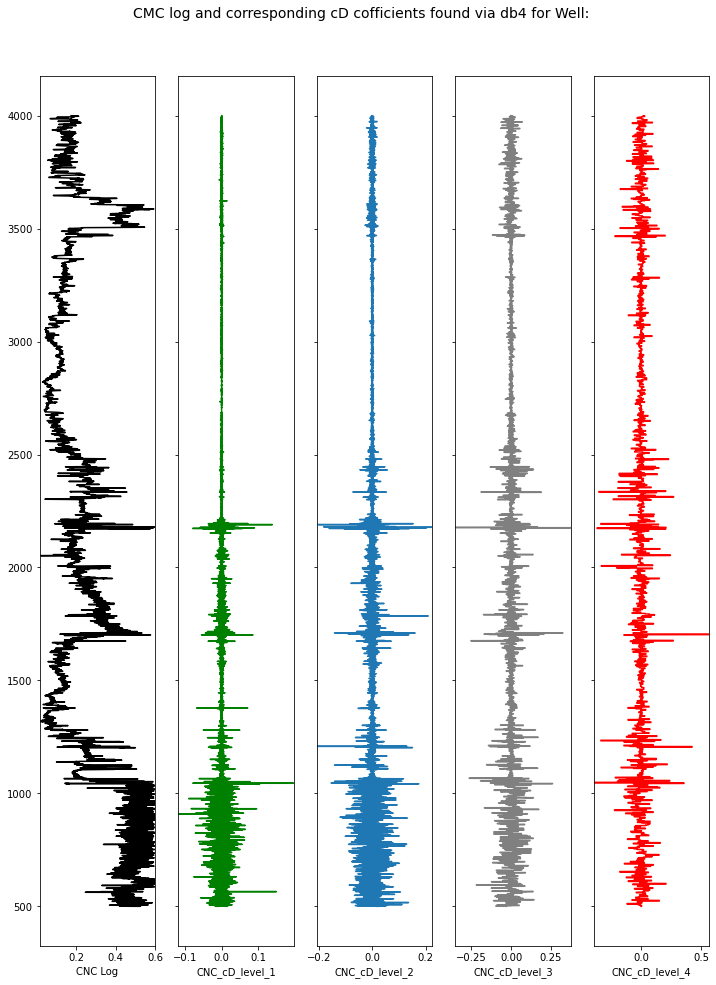

In [20]:
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 16))
ax[0].plot(df1.CNC, df1.Depth, '-', color='black')
ax[1].plot(df1.CNC_cD_level_1, df1.Depth, '-g')
ax[2].plot(df1.CNC_cD_level_2, df1.Depth, '-')
ax[3].plot(df1.CNC_cD_level_3, df1.Depth, '-', color='0.5')
ax[4].plot(df1.CNC_cD_level_4, df1.Depth, '-', color='r')

ax[0].set_xlabel("CNC Log")
ax[0].set_xlim(df1.CNC.min(),df1.CNC.max())
ax[1].set_xlabel("CNC_cD_level_1")
ax[1].set_xlim(df1.CNC_cD_level_1.min(),df1.CNC_cD_level_1.max())
ax[2].set_xlabel("CNC_cD_level_2")
ax[2].set_xlim(df1.CNC_cD_level_2.min(),df1.CNC_cD_level_2.max())
ax[3].set_xlabel("CNC_cD_level_3")
ax[3].set_xlim(df1.CNC_cD_level_3.min(),df1.CNC_cD_level_3.max())
ax[4].set_xlabel("CNC_cD_level_4")
ax[4].set_xlim(df1.CNC_cD_level_4.min(),df1.CNC_cD_level_4.max())

ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
ax[4].set_yticklabels([]); 

f.suptitle('CMC log and corresponding cD cofficients found via db4 for Well: ', fontsize=14,y=0.94)

db4 wavelet transform to test data

In [21]:
#cD From wavelet db4
dwt_db4_cD_df = make_dwt_vars_cD(wells_df=df2, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='db4')

# cA From wavelet db4
dwt_db4_cA_df = make_dwt_vars_cA(wells_df=df2, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='db4')

In [22]:
list_df_var = [dwt_db4_cD_df, dwt_db4_cA_df]
combined_df = df2
for var_df in list_df_var:
    temp_df = var_df
    combined_df = pd.concat([combined_df,temp_df],axis=1)
combined_df.replace(to_replace=np.nan, value='-1', inplace=True)
print (combined_df.shape)
training_data=combined_df

(99792, 17)


In [23]:
df2= training_data

Text(0.5, 0.94, 'CMC log and corresponding cD cofficients found via haar for Well: ')

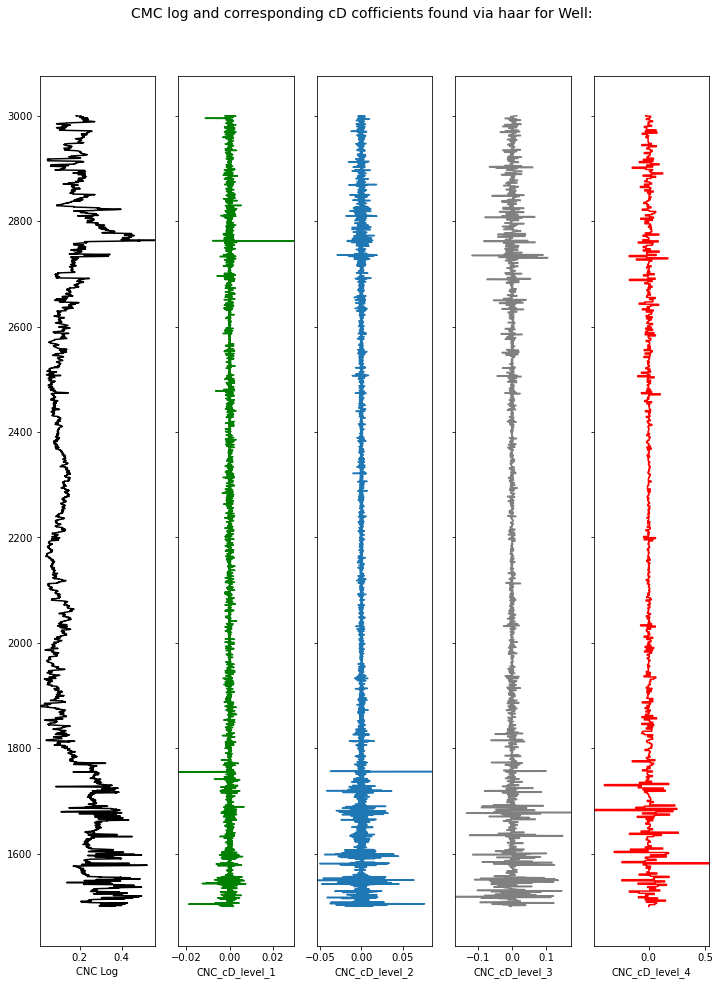

In [24]:
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 16))
ax[0].plot(df2.CNC, df2.Depth, '-', color='black')
ax[1].plot(df2.CNC_cD_level_1, df2.Depth, '-g')
ax[2].plot(df2.CNC_cD_level_2, df2.Depth, '-')
ax[3].plot(df2.CNC_cD_level_3, df2.Depth, '-', color='0.5')
ax[4].plot(df2.CNC_cD_level_4, df2.Depth, '-', color='r')

ax[0].set_xlabel("CNC Log")
ax[0].set_xlim(df2.CNC.min(),df2.CNC.max())
ax[1].set_xlabel("CNC_cD_level_1")
ax[1].set_xlim(df2.CNC_cD_level_1.min(),df2.CNC_cD_level_1.max())
ax[2].set_xlabel("CNC_cD_level_2")
ax[2].set_xlim(df2.CNC_cD_level_2.min(),df2.CNC_cD_level_2.max())
ax[3].set_xlabel("CNC_cD_level_3")
ax[3].set_xlim(df2.CNC_cD_level_3.min(),df2.CNC_cD_level_3.max())
ax[4].set_xlabel("CNC_cD_level_4")
ax[4].set_xlim(df2.CNC_cD_level_4.min(),df2.CNC_cD_level_4.max())

ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
ax[4].set_yticklabels([]); 

f.suptitle('CMC log and corresponding cD cofficients found via haar for Well: ', fontsize=14,y=0.94)

## haar wavelet transform 

In [25]:
df11 = pd.read_csv('train.csv')
df22= pd.read_csv('test.csv')

In [26]:
df11['CNC'][df11['CNC']>0.6]=np.nan
df11['CNC'][df11['CNC']<-0.15]=np.nan

In [27]:
# Delete points where data are missing 
df11=df11[['CNC','GR','ZDEN','HRD','DTC','DTS','CAL','HRM','PE']]
df11.replace(['-999', -999], np.nan, inplace=True)
df11.dropna(axis=0, inplace=True)
df22=df22[['CNC','GR','ZDEN','HRD','CAL','HRM','PE']]
df22.replace(['-999', -999], np.nan, inplace=True)
df22.dropna(axis=0, inplace=True)

DTC2=np.zeros(df22.shape[0])# array for saving predictions
DTS2=np.zeros(df22.shape[0])

In [28]:
depth_train= np.linspace(500,4000,len(df11))
depth_test= np.linspace(1500,3000,len(df22))

In [29]:
df11['Depth']= depth_train
df22['Depth']= depth_test

In [30]:
df1_haar = df11
df2_haar = df22

For train data

In [31]:
#cD From wavelet db4
dwt_db4_cD_df = make_dwt_vars_cD(wells_df=df1_haar, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='haar')

# cA From wavelet db4
dwt_db4_cA_df = make_dwt_vars_cA(wells_df=df1_haar, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='haar')

In [32]:
list_df_var = [dwt_db4_cD_df, dwt_db4_cA_df]
combined_df = df1_haar
for var_df in list_df_var:
    temp_df = var_df
    combined_df = pd.concat([combined_df,temp_df],axis=1)
combined_df.replace(to_replace=np.nan, value='-1', inplace=True)
print (combined_df.shape)
training_data=combined_df

(200680, 18)


In [33]:
df1_haar = training_data

Text(0.5, 0.94, 'CMC log and corresponding cD cofficients found via haar for Well: ')

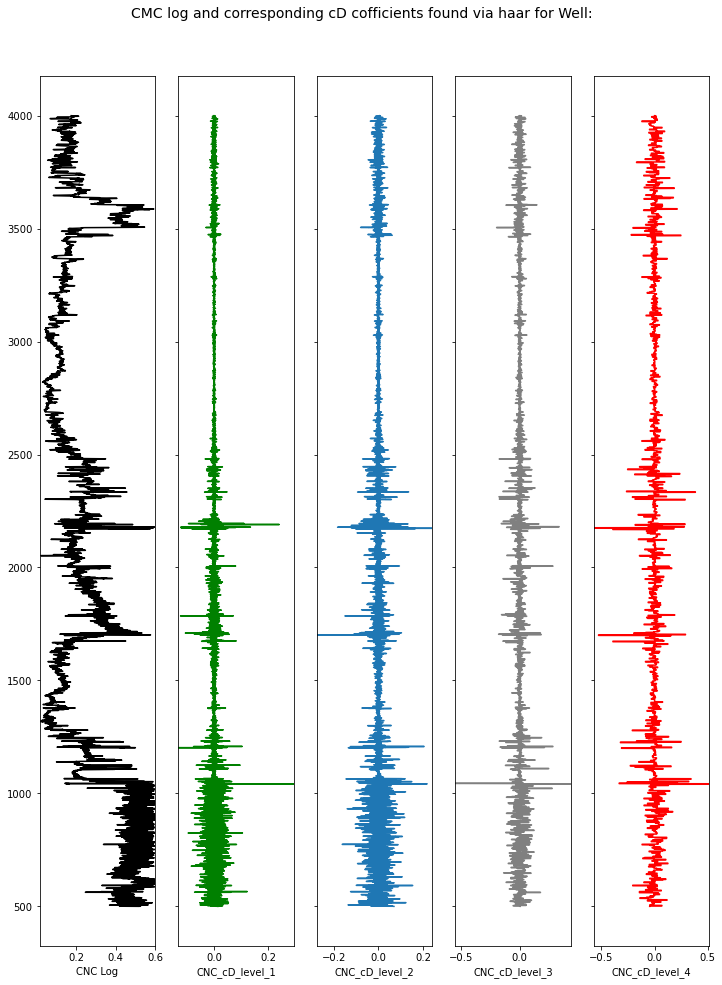

In [34]:
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 16))
ax[0].plot(df1_haar.CNC, df1_haar.Depth, '-', color='black')
ax[1].plot(df1_haar.CNC_cD_level_1, df1_haar.Depth, '-g')
ax[2].plot(df1_haar.CNC_cD_level_2, df1_haar.Depth, '-')
ax[3].plot(df1_haar.CNC_cD_level_3, df1_haar.Depth, '-', color='0.5')
ax[4].plot(df1_haar.CNC_cD_level_4, df1_haar.Depth, '-', color='r')

ax[0].set_xlabel("CNC Log")
ax[0].set_xlim(df1_haar.CNC.min(),df1.CNC.max())
ax[1].set_xlabel("CNC_cD_level_1")
ax[1].set_xlim(df1_haar.CNC_cD_level_1.min(),df1_haar.CNC_cD_level_1.max())
ax[2].set_xlabel("CNC_cD_level_2")
ax[2].set_xlim(df1_haar.CNC_cD_level_2.min(),df1_haar.CNC_cD_level_2.max())
ax[3].set_xlabel("CNC_cD_level_3")
ax[3].set_xlim(df1_haar.CNC_cD_level_3.min(),df1_haar.CNC_cD_level_3.max())
ax[4].set_xlabel("CNC_cD_level_4")
ax[4].set_xlim(df1_haar.CNC_cD_level_4.min(),df1_haar.CNC_cD_level_4.max())

ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
ax[4].set_yticklabels([]); 

f.suptitle('CMC log and corresponding cD cofficients found via haar for Well: ', fontsize=14,y=0.94)

For test data

In [35]:
#cD From wavelet db4
dwt_db4_cD_df = make_dwt_vars_cD(wells_df=df2_haar, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='haar')

# cA From wavelet db4
dwt_db4_cA_df = make_dwt_vars_cA(wells_df=df2_haar, logs=['CNC'],levels=[1, 2, 3, 4], wavelet='haar')

In [36]:
list_df_var = [dwt_db4_cD_df, dwt_db4_cA_df]
combined_df = df2_haar
for var_df in list_df_var:
    temp_df = var_df
    combined_df = pd.concat([combined_df,temp_df],axis=1)
combined_df.replace(to_replace=np.nan, value='-1', inplace=True)
print (combined_df.shape)
training_data=combined_df

(88704, 16)


In [37]:
df2_haar = training_data

Text(0.5, 0.94, 'CMC log and corresponding cD cofficients found via haar for Well: ')

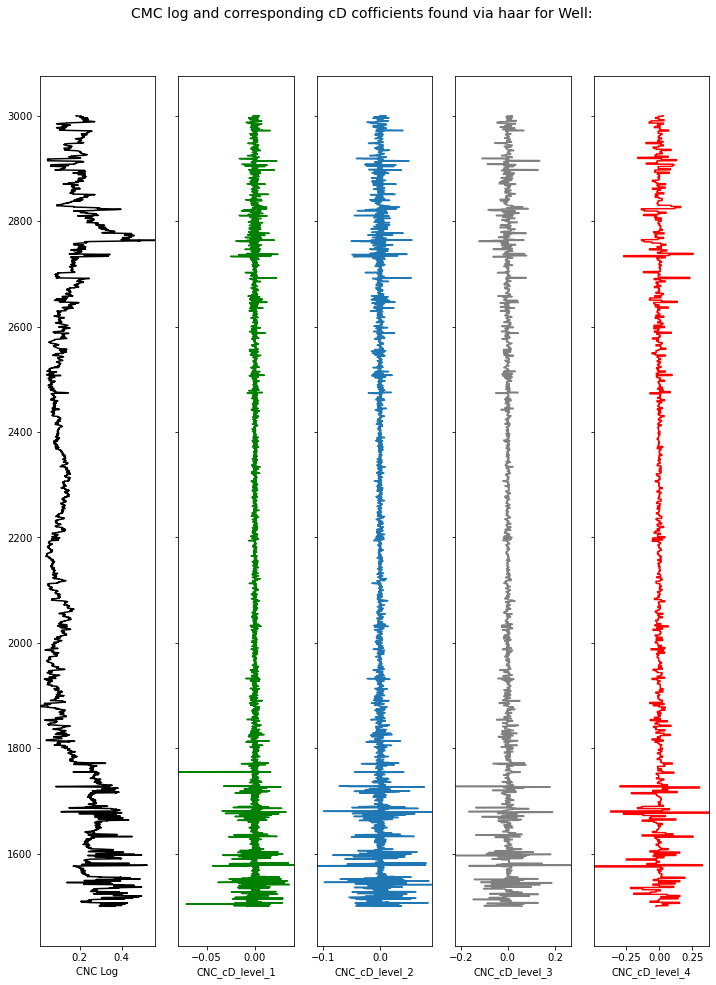

In [38]:
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 16))
ax[0].plot(df2_haar.CNC, df2_haar.Depth, '-', color='black')
ax[1].plot(df2_haar.CNC_cD_level_1, df2_haar.Depth, '-g')
ax[2].plot(df2_haar.CNC_cD_level_2, df2_haar.Depth, '-')
ax[3].plot(df2_haar.CNC_cD_level_3, df2_haar.Depth, '-', color='0.5')
ax[4].plot(df2_haar.CNC_cD_level_4, df2_haar.Depth, '-', color='r')

ax[0].set_xlabel("CNC Log")
ax[0].set_xlim(df2_haar.CNC.min(),df2_haar.CNC.max())
ax[1].set_xlabel("CNC_cD_level_1")
ax[1].set_xlim(df2_haar.CNC_cD_level_1.min(),df2_haar.CNC_cD_level_1.max())
ax[2].set_xlabel("CNC_cD_level_2")
ax[2].set_xlim(df2_haar.CNC_cD_level_2.min(),df2_haar.CNC_cD_level_2.max())
ax[3].set_xlabel("CNC_cD_level_3")
ax[3].set_xlim(df2_haar.CNC_cD_level_3.min(),df2_haar.CNC_cD_level_3.max())
ax[4].set_xlabel("CNC_cD_level_4")
ax[4].set_xlim(df2_haar.CNC_cD_level_4.min(),df2_haar.CNC_cD_level_4.max())

ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
ax[4].set_yticklabels([]); 

f.suptitle('CMC log and corresponding cD cofficients found via haar for Well: ', fontsize=14,y=0.94)

### db4 transform for train and test data are stored in df1 and df2
### haar transfrom for train and test data are stored in df1_haar and df2_haar

In [39]:
df1.head()

,CNC,GR,ZDEN,HRD,DTC,DTS,zone,CAL,HRM,PE,Depth,CNC_cD_level_1,CNC_cD_level_2,CNC_cD_level_3,CNC_cD_level_4,CNC_cA_level_1,CNC_cA_level_2,CNC_cA_level_3,CNC_cA_level_4
573,0.5173,57.1903,2.351,1.9826,125.9611,306.8676,1,14.8824,1.9726,27.9432,500.0,-0.00827,0.017488,-0.029477,0.001136,0.620461,0.914535,1.332195,1.873627
573,0.5173,57.1903,2.351,1.9826,125.9611,306.8676,1,14.8824,1.9726,27.9432,500.0,-0.00827,0.017488,-0.029477,0.001136,0.620461,0.914535,1.332195,1.873627
573,0.5173,57.1903,2.351,1.9826,125.9611,306.8676,1,14.8824,1.9726,27.9432,500.0,-0.00827,0.017488,-0.029477,0.001136,0.620461,0.914535,1.332195,1.873627
573,0.5173,57.1903,2.351,1.9826,125.9611,306.8676,1,14.8824,1.9726,27.9432,500.0,-0.00827,0.017488,-0.029477,0.001136,0.620461,0.914535,1.332195,1.873627
573,0.5173,57.1903,2.351,1.9826,125.9611,306.8676,1,14.8824,1.9726,27.9432,500.0,-0.00827,0.017488,-0.029477,0.001136,0.620461,0.914535,1.332195,1.873627


In [40]:
df2.head()

,CNC,GR,ZDEN,HRD,zone,CAL,HRM,PE,Depth,CNC_cD_level_1,CNC_cD_level_2,CNC_cD_level_3,CNC_cD_level_4,CNC_cA_level_1,CNC_cA_level_2,CNC_cA_level_3,CNC_cA_level_4
0,0.3521,55.1824,2.3256,0.8121,1,8.5781,0.781,6.8291,1500.0,0.001117,-0.006163,-0.003264,0.000376,0.497537,0.716567,1.010954,1.42652
0,0.3521,55.1824,2.3256,0.8121,1,8.5781,0.781,6.8291,1500.0,0.001117,-0.006163,-0.003264,0.000376,0.497537,0.716567,1.010954,1.42652
0,0.3521,55.1824,2.3256,0.8121,1,8.5781,0.781,6.8291,1500.0,0.001117,-0.006163,-0.003264,0.000376,0.497537,0.716567,1.010954,1.42652
0,0.3521,55.1824,2.3256,0.8121,1,8.5781,0.781,6.8291,1500.0,0.001117,-0.006163,-0.003264,0.000376,0.497537,0.716567,1.010954,1.42652
0,0.3521,55.1824,2.3256,0.8121,1,8.5781,0.781,6.8291,1500.0,0.001117,-0.006163,-0.003264,0.000376,0.497537,0.716567,1.010954,1.42652


In [41]:
df1_haar.head()

,CNC,GR,ZDEN,HRD,DTC,DTS,CAL,HRM,PE,Depth,CNC_cD_level_1,CNC_cD_level_2,CNC_cD_level_3,CNC_cD_level_4,CNC_cA_level_1,CNC_cA_level_2,CNC_cA_level_3,CNC_cA_level_4
573,0.5173,57.1903,2.351,1.9826,125.9611,306.8676,14.8824,1.9726,27.9432,500.0,0.014637,0.06985,0.004844,-0.046175,0.716936,0.94405,1.330245,1.927425
573,0.5173,57.1903,2.351,1.9826,125.9611,306.8676,14.8824,1.9726,27.9432,500.0,0.014637,0.06985,0.004844,-0.046175,0.716936,0.94405,1.330245,1.927425
573,0.5173,57.1903,2.351,1.9826,125.9611,306.8676,14.8824,1.9726,27.9432,500.0,0.014637,0.06985,0.004844,-0.046175,0.716936,0.94405,1.330245,1.927425
573,0.5173,57.1903,2.351,1.9826,125.9611,306.8676,14.8824,1.9726,27.9432,500.0,0.014637,0.06985,0.004844,-0.046175,0.716936,0.94405,1.330245,1.927425
573,0.5173,57.1903,2.351,1.9826,125.9611,306.8676,14.8824,1.9726,27.9432,500.0,0.014637,0.06985,0.004844,-0.046175,0.716936,0.94405,1.330245,1.927425


In [42]:
df2_haar.head()

,CNC,GR,ZDEN,HRD,CAL,HRM,PE,Depth,CNC_cD_level_1,CNC_cD_level_2,CNC_cD_level_3,CNC_cD_level_4,CNC_cA_level_1,CNC_cA_level_2,CNC_cA_level_3,CNC_cA_level_4
0,0.3521,55.1824,2.3256,0.8121,8.5781,0.781,6.8291,1500.0,-0.008344,-0.0105,0.060245,-0.024025,0.506288,0.7265,0.967181,1.391825
0,0.3521,55.1824,2.3256,0.8121,8.5781,0.781,6.8291,1500.0,-0.008344,-0.0105,0.060245,-0.024025,0.506288,0.7265,0.967181,1.391825
0,0.3521,55.1824,2.3256,0.8121,8.5781,0.781,6.8291,1500.0,-0.008344,-0.0105,0.060245,-0.024025,0.506288,0.7265,0.967181,1.391825
0,0.3521,55.1824,2.3256,0.8121,8.5781,0.781,6.8291,1500.0,-0.008344,-0.0105,0.060245,-0.024025,0.506288,0.7265,0.967181,1.391825
0,0.3521,55.1824,2.3256,0.8121,8.5781,0.781,6.8291,1500.0,-0.008344,-0.0105,0.060245,-0.024025,0.506288,0.7265,0.967181,1.391825


to see the variation if wavelet transform has worked or not

Text(0.5, 0.94, 'CMC log and corresponding cD cofficients found via db4 for Well: ')

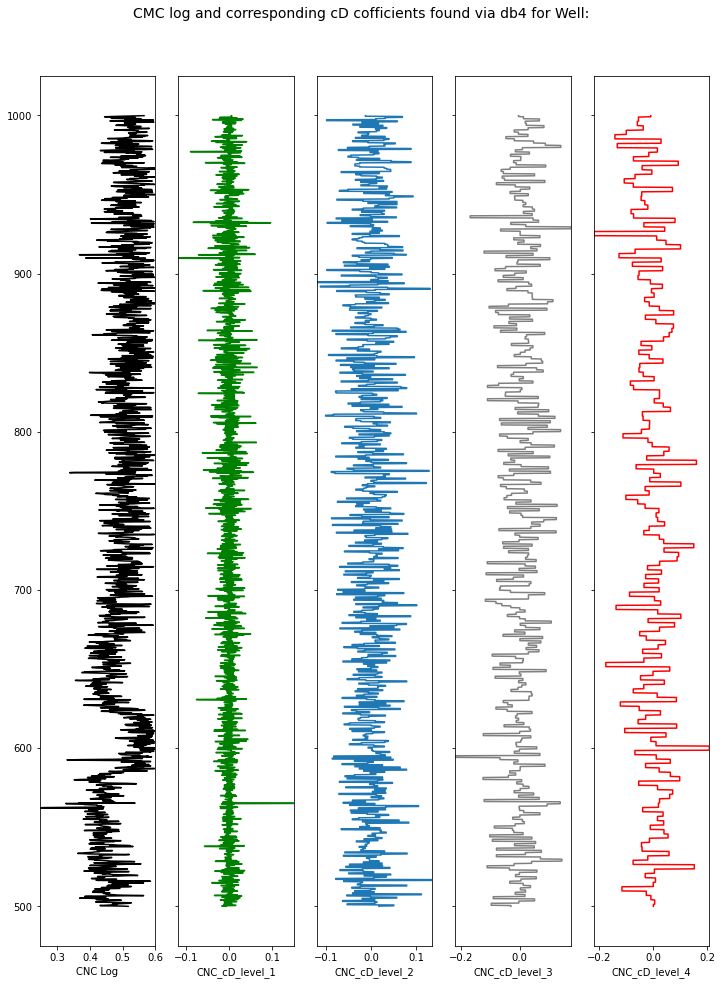

In [43]:
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 16))
ax[0].plot(df_zone1.CNC, df_zone1.Depth, '-', color='black')
ax[1].plot(df_zone1.CNC_cD_level_1, df_zone1.Depth, '-g')
ax[2].plot(df_zone1.CNC_cD_level_2, df_zone1.Depth, '-')
ax[3].plot(df_zone1.CNC_cD_level_3, df_zone1.Depth, '-', color='0.5')
ax[4].plot(df_zone1.CNC_cD_level_4, df_zone1.Depth, '-', color='r')

ax[0].set_xlabel("CNC Log")
ax[0].set_xlim(df_zone1.CNC.min(),df_zone1.CNC.max())
ax[1].set_xlabel("CNC_cD_level_1")
ax[1].set_xlim(df_zone1.CNC_cD_level_1.min(),df_zone1.CNC_cD_level_1.max())
ax[2].set_xlabel("CNC_cD_level_2")
ax[2].set_xlim(df_zone1.CNC_cD_level_2.min(),df_zone1.CNC_cD_level_2.max())
ax[3].set_xlabel("CNC_cD_level_3")
ax[3].set_xlim(df_zone1.CNC_cD_level_3.min(),df_zone1.CNC_cD_level_3.max())
ax[4].set_xlabel("CNC_cD_level_4")
ax[4].set_xlim(df_zone1.CNC_cD_level_4.min(),df_zone1.CNC_cD_level_4.max())

ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
ax[4].set_yticklabels([]); 

f.suptitle('CMC log and corresponding cD cofficients found via db4 for Well: ', fontsize=14,y=0.94)

## Predictions for db4 wavelet data

In [44]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2) 
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import median_filter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.signal import medfilt
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint
import keras
import warnings
warnings.filterwarnings('ignore')

In [148]:
df1.shape

(220748, 40)

In [46]:
df1= df1.drop(['Depth'],axis=1)
df2= df2.drop(['Depth'],axis=1)

In [60]:
DTS2.shape

(23081,)

In [49]:
df_plot=df1.copy()
df_plot['CNC'][df_plot['CNC']>0.6]=np.nan
df_plot['CNC'][df_plot['CNC']<-0.15]=np.nan
df_plot['GR'][df_plot['GR']>250]=150
df_plot.dropna(axis=0, inplace=True)
#g=sb.pairplot(df_plot[['ZDEN', 'CNC','GR','DTC','DTS','zone']],hue='zone')

In [50]:
# Preprocessing: 10000 data points in the test well should roughly correspond to 5000 ft, 
# which is too long for a well, thus we think it could be resampled. The artifacts in the cross plots (continuous dots)
# also indicate the existence of resampling.
# To alieviate the aliasing problem caused by resampling, and try to restore the true correlation,
# we calculate gradients to differentiate
# real data from interpolated data, and use medidan filter to capture the general trends of different well logs.

#Perform logrithmic transformation to resistivity logs to avoid large weight on resisitivity logs
df1['HRD_log']=np.log(df1.HRD.values)
df2['HRD_log']=np.log(df2.HRD.values)
df1['HRM_log']=np.log(df1.HRM.values)
df2['HRM_log']=np.log(df2.HRM.values)

# Calculate the gradients of input logs
# Interpolated well logs should have similar gradients
for i in df1.keys():
    df1[i+'grad']=np.gradient(df1[i].values)
for i in df2.keys():
    df2[i+'grad']=np.gradient(df2[i].values)
#Observe the patterns of logs


In [51]:
df1.columns

Index(['CNC', 'GR', 'ZDEN', 'HRD', 'DTC', 'DTS', 'zone', 'CAL', 'HRM', 'PE',
       'CNC_cD_level_1', 'CNC_cD_level_2', 'CNC_cD_level_3', 'CNC_cD_level_4',
       'CNC_cA_level_1', 'CNC_cA_level_2', 'CNC_cA_level_3', 'CNC_cA_level_4',
       'HRD_log', 'HRM_log', 'CNCgrad', 'GRgrad', 'ZDENgrad', 'HRDgrad',
       'DTCgrad', 'DTSgrad', 'zonegrad', 'CALgrad', 'HRMgrad', 'PEgrad',
       'CNC_cD_level_1grad', 'CNC_cD_level_2grad', 'CNC_cD_level_3grad',
       'CNC_cD_level_4grad', 'CNC_cA_level_1grad', 'CNC_cA_level_2grad',
       'CNC_cA_level_3grad', 'CNC_cA_level_4grad', 'HRD_loggrad',
       'HRM_loggrad'],
      dtype='object')

In [52]:
df2.columns

Index(['CNC', 'GR', 'ZDEN', 'HRD', 'zone', 'CAL', 'HRM', 'PE',
       'CNC_cD_level_1', 'CNC_cD_level_2', 'CNC_cD_level_3', 'CNC_cD_level_4',
       'CNC_cA_level_1', 'CNC_cA_level_2', 'CNC_cA_level_3', 'CNC_cA_level_4',
       'HRD_log', 'HRM_log', 'CNCgrad', 'GRgrad', 'ZDENgrad', 'HRDgrad',
       'zonegrad', 'CALgrad', 'HRMgrad', 'PEgrad', 'CNC_cD_level_1grad',
       'CNC_cD_level_2grad', 'CNC_cD_level_3grad', 'CNC_cD_level_4grad',
       'CNC_cA_level_1grad', 'CNC_cA_level_2grad', 'CNC_cA_level_3grad',
       'CNC_cA_level_4grad', 'HRD_loggrad', 'HRM_loggrad'],
      dtype='object')

In [53]:
from sklearn.model_selection import train_test_split

In [62]:
for iiii in [0,1,2,3,4]:
    df=df1[df1.zone.values==iiii].copy()
    #df_test=df2[df2.zone.values==iiii].copy()
    X= df.drop(['DTS','DTC'],axis=1)
    y= df[['DTS','DTC']]
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    df= X_train
    x=df[['CNC','GR','ZDEN','HRD_log','HRM_log','PE','CNCgrad','GRgrad','ZDENgrad','CNC_cD_level_1', 'CNC_cD_level_2', 'CNC_cD_level_3', 'CNC_cD_level_4',
       'CNC_cA_level_1', 'CNC_cA_level_2', 'CNC_cA_level_3', 'CNC_cA_level_4']].copy()
    DTC2=np.zeros(len(X_test))# array for saving predictions
    DTS2=np.zeros(len(X_test))
    # To remove the noise, preserve the relative magnitude of the signals and given the fact that the vertical resolution of sonic logs are 
    #not as high as other logs, we use median filter to preprocessing the input features.
    for i in x.keys():
        x[i]=median_filter(df[i].values,21,mode='nearest')
    y= Y_train
    
    # Minmax scaling is used to constrain the range of the output.
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_train = scaler_X.fit_transform(x.values)
    x_train=np.concatenate([x_train[1:-1],x_train[0:-2],x_train[2:]],axis=-1)    
    y_train = scaler_y.fit_transform(y.values)
    y_train = y_train[1:-1]
    
    #same operations are applied to test set.
    x_test=X_test[['CNC','GR','ZDEN','HRD_log','HRM_log','PE','CNCgrad','GRgrad','ZDENgrad','CNC_cD_level_1', 'CNC_cD_level_2', 'CNC_cD_level_3', 'CNC_cD_level_4',
       'CNC_cA_level_1', 'CNC_cA_level_2', 'CNC_cA_level_3', 'CNC_cA_level_4']].values#,'RM_log'
    for i in range(x_test.shape[1]):
        x_test[:,i]=median_filter(x_test[:,i],21,mode='nearest')
    x_test=scaler_X.transform(x_test)
    # To account for spatial correlations, we add window to take into account the effects of logs at adjacent depths.
    # add window
    x_test=np.concatenate([x_test[1:-1],x_test[0:-2],x_test[2:]],axis=-1) 

    # A simple fully connected neural network is used for prediction
    model_1 = Sequential([
        Dense(24, activation='relu', input_shape=(51,)),
        Dense(12, activation='relu'),
        Dense(2,activation='sigmoid'),
    ])
 

    
    model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])
    np.random.seed(1)
    tf.random.set_seed(2)
    
    save_model_name = str(iiii)+'_Model'
    model_checkpoint = ModelCheckpoint(save_model_name,monitor='loss', mode = 'min', save_best_only=True, verbose=1)
    #train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    #valid_data = tf.data.Dataset.from_tensor_slices((testMixed, testVocals))
    hist_1 = model_1.fit(x_train, y_train, batch_size=10, epochs=9, callbacks=[model_checkpoint])
    
    y_test2=model_1.predict(x_test)
    y_test2=scaler_y.inverse_transform(y_test2)
    y_test2=np.concatenate([y_test2[0:1,:],y_test2,y_test2[-1:,:]],axis=0)
    # save the prediction
    DTC2[X_test.zone.values==iiii]=y_test2[:,0]
    DTS2[X_test.zone.values==iiii]=y_test2[:,1]

Epoch 1/9
5386/5386 [==============================] - 7s 1ms/step - loss: 0.0843 - mae: 0.2500A: 0s - loss: 0.0843 - mae: 0.25

Epoch 00001: loss improved from inf to 0.08383, saving model to 0_Model
INFO:tensorflow:Assets written to: 0_Model\assets
Epoch 2/9
5386/5386 [==============================] - 5s 1ms/step - loss: 0.0843 - mae: 0.2497

Epoch 00002: loss improved from 0.08383 to 0.08352, saving model to 0_Model
INFO:tensorflow:Assets written to: 0_Model\assets
Epoch 3/9
5386/5386 [==============================] - 5s 986us/step - loss: 0.0834 - mae: 0.2474

Epoch 00003: loss improved from 0.08352 to 0.08343, saving model to 0_Model
INFO:tensorflow:Assets written to: 0_Model\assets
Epoch 4/9
5386/5386 [==============================] - 6s 1ms/step - loss: 0.0834 - mae: 0.2471

Epoch 00004: loss did not improve from 0.08343
Epoch 5/9
5386/5386 [==============================] - 6s 1ms/step - loss: 0.0837 - mae: 0.2483

Epoch 00005: loss improved from 0.08343 to 0.08333, saving m

2548/2548 [==============================] - 3s 1ms/step - loss: 0.0202 - mae: 0.1022

Epoch 00003: loss improved from 0.02025 to 0.02020, saving model to 4_Model
INFO:tensorflow:Assets written to: 4_Model\assets
Epoch 4/9
2548/2548 [==============================] - 3s 1ms/step - loss: 0.0201 - mae: 0.1020

Epoch 00004: loss improved from 0.02020 to 0.02019, saving model to 4_Model
INFO:tensorflow:Assets written to: 4_Model\assets
Epoch 5/9
2548/2548 [==============================] - 3s 1ms/step - loss: 0.0198 - mae: 0.1011

Epoch 00005: loss did not improve from 0.02019
Epoch 6/9
2548/2548 [==============================] - 3s 1ms/step - loss: 0.0201 - mae: 0.1021

Epoch 00006: loss improved from 0.02019 to 0.02018, saving model to 4_Model
INFO:tensorflow:Assets written to: 4_Model\assets
Epoch 7/9
2548/2548 [==============================] - 3s 1ms/step - loss: 0.0200 - mae: 0.1016

Epoch 00007: loss improved from 0.02018 to 0.02016, saving model to 4_Model
INFO:tensorflow:Assets w

In [96]:
# Create separate datasets for DTC and DTS
df_dtc = df1.dropna(subset=['DTC'])
df_dts = df1.dropna(subset=['DTS'])

In [118]:
dts= y_pred_test_dts

In [119]:
dtc= y_pred_test_dtc

In [124]:
merge= [y_test_dtc,y_test_dts]
pd.concat(merge,axis=1)

,DTC,DTS
23764,68.6973,126.0240
22089,67.1378,124.1802
24913,70.9434,129.9110
26401,72.6878,131.4244
22055,66.9033,123.8435
...,...,...
2956,135.1063,388.8326
14466,76.5578,151.4752
17190,111.2666,203.4224
23202,65.3069,122.8605


In [133]:
# Compute estimations:
y_20test_ = np.concatenate([dtc.reshape(dtc.shape[0],1), dts.reshape(dts.shape[0],1)], axis=1) 
y_20true_ = pd.concat(merge,axis=1).values

RMSE of test data (#1 DTC): 3.32
RMSE of test data (#2 DTS): 2.61
Overall RMSE = 2.99


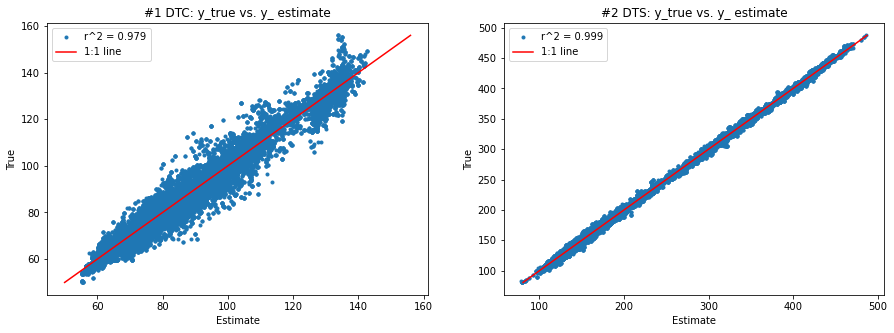

In [135]:
# Plot results:
plt.figure(figsize=(15,5))
i = 0
plt.subplot(1,2,i+1)
plt.plot(y_20test_[:,i], y_20true_[:,i], '.', label = 'r^2 = %.3f' % (r2_score(y_20true_[:,i], y_20test_[:,i])))
plt.plot([y_20true_[:,i].min(),y_20true_[:,i].max()],[y_20true_[:,i].min(),y_20true_[:,i].max()], 'r', label = '1:1 line')
plt.title('#1 DTC: y_true vs. y_ estimate'); plt.xlabel('Estimate'); plt.ylabel('True')
plt.legend()
i += 1
plt.subplot(1,2,i+1)
plt.plot(y_20test_[:,i], y_20true_[:,i], '.', label = 'r^2 = %.3f' % (r2_score(y_20true_[:,i], y_20test_[:,i])))
plt.plot([y_20true_[:,i].min(),y_20true_[:,i].max()],[y_20true_[:,i].min(),y_20true_[:,i].max()], 'r', label = '1:1 line')
plt.title('#2 DTS: y_true vs. y_ estimate'); plt.xlabel('Estimate'); plt.ylabel('True')
plt.legend()

MSE_0 = mean_squared_error(y_20true_[:,0], y_20test_[:,0]);
RMSE_0 = np.sqrt(mean_squared_error(y_20true_[:,0], y_20test_[:,0]));
MSE_1 = mean_squared_error(y_20true_[:,1], y_20test_[:,1]);
RMSE_1 = np.sqrt(mean_squared_error(y_20true_[:,1], y_20test_[:,1]));
print('RMSE of test data (#1 DTC): %.2f' %(RMSE_0))
print('RMSE of test data (#2 DTS): %.2f' %(RMSE_1))
print('Overall RMSE = %.2f' %np.sqrt((MSE_0+MSE_1)/2))